# Treinamento - Dataset 1

## Imports

In [11]:
import os
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

from tensorflow.keras.utils import normalize

from tensorflow.keras.layers import Input,LeakyReLU

from tensorflow.keras.initializers import he_normal

import gc

## Desabilitando uso da GPU - apenas no caso da instalação do tensorflow com suporte a GPU

* O uso da GPU traz banefícios de desempenho para modelos médios e grandes apenas

In [12]:
# force CPU (make CPU visible)
cpus = tf.config.experimental.list_physical_devices('CPU')
print(cpus)
tf.config.set_visible_devices([], 'GPU')  # hide the GPU
tf.config.set_visible_devices(cpus[0], 'CPU') # unhide potentially hidden CPU
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Leitura dos dados

In [13]:
dataPath = r'D:\14--OneDrive\OneDrive\ML-SEA-2021\Rede_Teste_2'
#npzFname = 'training_data_sw_ar_clean.npz'
npzFname = 'training_data_sw_ar_raw.npz'

npz = np.load(os.path.join(dataPath, npzFname))

X_TRAIN = npz['X_TRAIN']
Y_TRAIN = npz['Y_TRAIN']

X_TEST = npz['X_TEST']
Y_TEST = npz['Y_TEST']

m_train = X_TRAIN.shape[0]
m_test = X_TEST.shape[0]
n_inp = X_TRAIN.shape[1]
n_out = Y_TRAIN.shape[1]
print('{:>30}{:8}'.format('Number of TRAINING samples:', m_train))
print('{:>30}{:8}'.format('Number of TEST samples:', m_test))
print('{:>30}{:8}'.format('Number of features:', n_inp))
print('{:>30}{:8}'.format('Number of labels:', n_out))

   Number of TRAINING samples:     950
       Number of TEST samples:     950
           Number of features:       2
             Number of labels:       1


## Normalização dos dados



### Definição da classe com método de normalização
É mais conveniente se utilizar uma classe pois sua instância guardará as informação da normalização 
que serão utilizadas no final do processo para desnormalizar a saída da rede

In [14]:
class normalizer:
    
    def __init__(self):       
        pass
    
    def set_norm(self, A, axis=0):
        self.mean = np.mean(A, axis=axis)
        self.std = np.std(A, axis=axis)
        
    def normalize(self, A):
        return (A - self.mean) / self.std
    
    def denormalize(self, A):
        return A * self.std + self.mean

### Criação e setup dos objetos normalizadores

In [15]:
inp_normalizer = normalizer()
inp_normalizer.set_norm(X_TRAIN)

out_normalizer = normalizer()
out_normalizer.set_norm(Y_TRAIN)

X_TRAIN_norm = inp_normalizer.normalize(X_TRAIN)
Y_TRAIN_norm = out_normalizer.normalize(Y_TRAIN)
X_TEST_norm = inp_normalizer.normalize(X_TEST)
Y_TEST_norm = out_normalizer.normalize(Y_TEST)

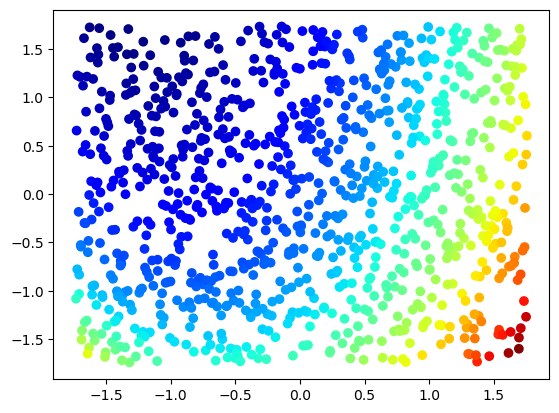

In [16]:
import matplotlib.pyplot as plt
plt.scatter(X_TRAIN_norm[:,0], X_TRAIN_norm[:,1], c=Y_TRAIN_norm[:,0], cmap='jet')
plt.show()

## Montagem do modelo / gráfico do Tensorflow

In [17]:
activation_func = 'tanh'

inp = Input(shape=(n_inp,))

n_prev = n_inp
n_layer = 16



x = Dense(n_layer, input_dim=n_prev, use_bias = True, 
          kernel_initializer=he_normal(seed=None), bias_initializer='zeros')(inp)
x = Activation(activation_func)(x)

n_prev = n_layer
n_layer = 16
x = Dense(n_layer, input_dim=n_prev, use_bias = True, 
          kernel_initializer=he_normal(seed=None), bias_initializer='zeros')(x)
x = Activation(activation_func)(x)

n_prev = n_layer
n_layer = 16
x = Dense(n_layer, input_dim=n_prev, use_bias = True, 
          kernel_initializer=he_normal(seed=None), bias_initializer='zeros')(x)
x = Activation(activation_func)(x)


n_prev = n_layer
x = Dense(n_out, input_dim=n_prev, use_bias = True, 
          kernel_initializer=he_normal(seed=None), bias_initializer='zeros')(x)
output = Activation('linear')(x)

### Setup do otimizador, métricas e compilação dos modelos

In [18]:
adam = Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999, epsilon=1.e-8, decay=0.1, amsgrad=False)

metric1 = metrics.MeanSquaredError(name='mse', dtype=None)
metric2 = metrics.MeanAbsolutePercentageError(name='mape', dtype=None)

model = Model(inp,output)

model.compile(loss='mse',
              optimizer=adam,
              metrics = [metric2])

### Treinamento

In [24]:
#model.summary()

model.fit(X_TRAIN_norm, Y_TRAIN_norm,
          epochs=1000,
          batch_size=64,
         shuffle=True,
         verbose = 2,
         validation_data =(X_TEST_norm, 
                           Y_TEST_norm))

Epoch 1/1000
15/15 - 0s - loss: 3.3296e-04 - mape: 5.0770 - val_loss: 3.3120e-04 - val_mape: 5.0835
Epoch 2/1000
15/15 - 0s - loss: 3.3281e-04 - mape: 5.0725 - val_loss: 3.3115e-04 - val_mape: 5.0594
Epoch 3/1000
15/15 - 0s - loss: 3.3223e-04 - mape: 5.0591 - val_loss: 3.3085e-04 - val_mape: 4.9682
Epoch 4/1000
15/15 - 0s - loss: 3.3257e-04 - mape: 5.0381 - val_loss: 3.3106e-04 - val_mape: 5.0872
Epoch 5/1000
15/15 - 0s - loss: 3.3223e-04 - mape: 5.0296 - val_loss: 3.3044e-04 - val_mape: 5.0225
Epoch 6/1000
15/15 - 0s - loss: 3.3257e-04 - mape: 5.0904 - val_loss: 3.3021e-04 - val_mape: 4.9843
Epoch 7/1000
15/15 - 0s - loss: 3.3295e-04 - mape: 4.9114 - val_loss: 3.3006e-04 - val_mape: 5.0417
Epoch 8/1000
15/15 - 0s - loss: 3.3233e-04 - mape: 5.0621 - val_loss: 3.2990e-04 - val_mape: 5.0531
Epoch 9/1000
15/15 - 0s - loss: 3.3150e-04 - mape: 5.0256 - val_loss: 3.2965e-04 - val_mape: 5.0327
Epoch 10/1000
15/15 - 0s - loss: 3.3090e-04 - mape: 5.0512 - val_loss: 3.2951e-04 - val_mape: 5.0348

Epoch 83/1000
15/15 - 0s - loss: 3.1917e-04 - mape: 4.9696 - val_loss: 3.1866e-04 - val_mape: 4.8682
Epoch 84/1000
15/15 - 0s - loss: 3.1942e-04 - mape: 4.8784 - val_loss: 3.1839e-04 - val_mape: 4.9890
Epoch 85/1000
15/15 - 0s - loss: 3.1990e-04 - mape: 5.0982 - val_loss: 3.1817e-04 - val_mape: 4.9513
Epoch 86/1000
15/15 - 0s - loss: 3.2063e-04 - mape: 4.8207 - val_loss: 3.1817e-04 - val_mape: 4.8961
Epoch 87/1000
15/15 - 0s - loss: 3.1849e-04 - mape: 5.0648 - val_loss: 3.1840e-04 - val_mape: 5.0460
Epoch 88/1000
15/15 - 0s - loss: 3.1895e-04 - mape: 4.9451 - val_loss: 3.1773e-04 - val_mape: 4.8940
Epoch 89/1000
15/15 - 0s - loss: 3.2062e-04 - mape: 4.8712 - val_loss: 3.1793e-04 - val_mape: 4.9187
Epoch 90/1000
15/15 - 0s - loss: 3.1784e-04 - mape: 4.9465 - val_loss: 3.1767e-04 - val_mape: 4.9143
Epoch 91/1000
15/15 - 0s - loss: 3.1921e-04 - mape: 4.9506 - val_loss: 3.1751e-04 - val_mape: 4.9779
Epoch 92/1000
15/15 - 0s - loss: 3.1968e-04 - mape: 5.0240 - val_loss: 3.1730e-04 - val_map

Epoch 164/1000
15/15 - 0s - loss: 3.0885e-04 - mape: 4.8693 - val_loss: 3.0732e-04 - val_mape: 4.9288
Epoch 165/1000
15/15 - 0s - loss: 3.0873e-04 - mape: 4.8247 - val_loss: 3.0709e-04 - val_mape: 4.8257
Epoch 166/1000
15/15 - 0s - loss: 3.0888e-04 - mape: 4.9362 - val_loss: 3.0697e-04 - val_mape: 4.8531
Epoch 167/1000
15/15 - 0s - loss: 3.0863e-04 - mape: 4.8096 - val_loss: 3.0683e-04 - val_mape: 4.8801
Epoch 168/1000
15/15 - 0s - loss: 3.0809e-04 - mape: 4.8988 - val_loss: 3.0685e-04 - val_mape: 4.8352
Epoch 169/1000
15/15 - 0s - loss: 3.0700e-04 - mape: 4.8271 - val_loss: 3.0678e-04 - val_mape: 4.8517
Epoch 170/1000
15/15 - 0s - loss: 3.0799e-04 - mape: 4.8955 - val_loss: 3.0633e-04 - val_mape: 4.8460
Epoch 171/1000
15/15 - 0s - loss: 3.0883e-04 - mape: 4.7469 - val_loss: 3.0620e-04 - val_mape: 4.8210
Epoch 172/1000
15/15 - 0s - loss: 3.0728e-04 - mape: 4.8876 - val_loss: 3.0635e-04 - val_mape: 4.9350
Epoch 173/1000
15/15 - 0s - loss: 3.0832e-04 - mape: 5.0076 - val_loss: 3.0640e-04

Epoch 245/1000
15/15 - 0s - loss: 2.9810e-04 - mape: 4.7641 - val_loss: 2.9677e-04 - val_mape: 4.7687
Epoch 246/1000
15/15 - 0s - loss: 2.9871e-04 - mape: 4.7734 - val_loss: 2.9706e-04 - val_mape: 4.7942
Epoch 247/1000
15/15 - 0s - loss: 2.9884e-04 - mape: 4.7494 - val_loss: 2.9697e-04 - val_mape: 4.8533
Epoch 248/1000
15/15 - 0s - loss: 2.9785e-04 - mape: 4.7863 - val_loss: 2.9640e-04 - val_mape: 4.7755
Epoch 249/1000
15/15 - 0s - loss: 2.9723e-04 - mape: 4.8390 - val_loss: 2.9645e-04 - val_mape: 4.8102
Epoch 250/1000
15/15 - 0s - loss: 2.9851e-04 - mape: 4.8130 - val_loss: 2.9636e-04 - val_mape: 4.7243
Epoch 251/1000
15/15 - 0s - loss: 2.9739e-04 - mape: 4.8690 - val_loss: 2.9632e-04 - val_mape: 4.8354
Epoch 252/1000
15/15 - 0s - loss: 2.9791e-04 - mape: 4.6861 - val_loss: 2.9610e-04 - val_mape: 4.6956
Epoch 253/1000
15/15 - 0s - loss: 2.9716e-04 - mape: 4.7011 - val_loss: 2.9599e-04 - val_mape: 4.8329
Epoch 254/1000
15/15 - 0s - loss: 2.9736e-04 - mape: 4.8245 - val_loss: 2.9588e-04

Epoch 326/1000
15/15 - 0s - loss: 2.8844e-04 - mape: 4.7081 - val_loss: 2.8724e-04 - val_mape: 4.7367
Epoch 327/1000
15/15 - 0s - loss: 2.8891e-04 - mape: 4.7010 - val_loss: 2.8712e-04 - val_mape: 4.6962
Epoch 328/1000
15/15 - 0s - loss: 2.8906e-04 - mape: 4.8653 - val_loss: 2.8748e-04 - val_mape: 4.8343
Epoch 329/1000
15/15 - 0s - loss: 2.8845e-04 - mape: 4.6408 - val_loss: 2.8769e-04 - val_mape: 4.6235
Epoch 330/1000
15/15 - 0s - loss: 2.8958e-04 - mape: 4.7681 - val_loss: 2.8723e-04 - val_mape: 4.7507
Epoch 331/1000
15/15 - 0s - loss: 2.8864e-04 - mape: 4.7561 - val_loss: 2.8724e-04 - val_mape: 4.7895
Epoch 332/1000
15/15 - 0s - loss: 2.8752e-04 - mape: 4.6688 - val_loss: 2.8686e-04 - val_mape: 4.6925
Epoch 333/1000
15/15 - 0s - loss: 2.8796e-04 - mape: 4.7058 - val_loss: 2.8660e-04 - val_mape: 4.6437
Epoch 334/1000
15/15 - 0s - loss: 2.8785e-04 - mape: 4.7478 - val_loss: 2.8664e-04 - val_mape: 4.8153
Epoch 335/1000
15/15 - 0s - loss: 2.8827e-04 - mape: 4.7320 - val_loss: 2.8658e-04

Epoch 407/1000
15/15 - 0s - loss: 2.7982e-04 - mape: 4.6503 - val_loss: 2.7853e-04 - val_mape: 4.6099
Epoch 408/1000
15/15 - 0s - loss: 2.7930e-04 - mape: 4.6695 - val_loss: 2.7836e-04 - val_mape: 4.6440
Epoch 409/1000
15/15 - 0s - loss: 2.8307e-04 - mape: 4.6805 - val_loss: 2.7857e-04 - val_mape: 4.6536
Epoch 410/1000
15/15 - 0s - loss: 2.7890e-04 - mape: 4.7254 - val_loss: 2.7891e-04 - val_mape: 4.7349
Epoch 411/1000
15/15 - 0s - loss: 2.8015e-04 - mape: 4.6683 - val_loss: 2.7803e-04 - val_mape: 4.5975
Epoch 412/1000
15/15 - 0s - loss: 2.7935e-04 - mape: 4.6509 - val_loss: 2.7806e-04 - val_mape: 4.7236
Epoch 413/1000
15/15 - 0s - loss: 2.8081e-04 - mape: 4.6500 - val_loss: 2.7805e-04 - val_mape: 4.6346
Epoch 414/1000
15/15 - 0s - loss: 2.8186e-04 - mape: 4.5248 - val_loss: 2.7859e-04 - val_mape: 4.6389
Epoch 415/1000
15/15 - 0s - loss: 2.7902e-04 - mape: 4.7062 - val_loss: 2.7820e-04 - val_mape: 4.7064
Epoch 416/1000
15/15 - 0s - loss: 2.7976e-04 - mape: 4.6066 - val_loss: 2.7745e-04

Epoch 488/1000
15/15 - 0s - loss: 2.7238e-04 - mape: 4.7334 - val_loss: 2.7051e-04 - val_mape: 4.6645
Epoch 489/1000
15/15 - 0s - loss: 2.7061e-04 - mape: 4.5638 - val_loss: 2.7030e-04 - val_mape: 4.5201
Epoch 490/1000
15/15 - 0s - loss: 2.7244e-04 - mape: 4.6207 - val_loss: 2.7014e-04 - val_mape: 4.6114
Epoch 491/1000
15/15 - 0s - loss: 2.7179e-04 - mape: 4.6209 - val_loss: 2.6994e-04 - val_mape: 4.5878
Epoch 492/1000
15/15 - 0s - loss: 2.7066e-04 - mape: 4.5841 - val_loss: 2.6988e-04 - val_mape: 4.5458
Epoch 493/1000
15/15 - 0s - loss: 2.7109e-04 - mape: 4.5973 - val_loss: 2.6978e-04 - val_mape: 4.6072
Epoch 494/1000
15/15 - 0s - loss: 2.7143e-04 - mape: 4.6372 - val_loss: 2.6981e-04 - val_mape: 4.6127
Epoch 495/1000
15/15 - 0s - loss: 2.7043e-04 - mape: 4.6351 - val_loss: 2.6973e-04 - val_mape: 4.5681
Epoch 496/1000
15/15 - 0s - loss: 2.7066e-04 - mape: 4.6919 - val_loss: 2.6962e-04 - val_mape: 4.5899
Epoch 497/1000
15/15 - 0s - loss: 2.7098e-04 - mape: 4.6112 - val_loss: 2.6938e-04

Epoch 569/1000
15/15 - 0s - loss: 2.6541e-04 - mape: 4.7937 - val_loss: 2.6377e-04 - val_mape: 4.6547
Epoch 570/1000
15/15 - 0s - loss: 2.6398e-04 - mape: 4.6144 - val_loss: 2.6288e-04 - val_mape: 4.4675
Epoch 571/1000
15/15 - 0s - loss: 2.6461e-04 - mape: 4.5753 - val_loss: 2.6286e-04 - val_mape: 4.6472
Epoch 572/1000
15/15 - 0s - loss: 2.6337e-04 - mape: 4.6523 - val_loss: 2.6259e-04 - val_mape: 4.5460
Epoch 573/1000
15/15 - 0s - loss: 2.6352e-04 - mape: 4.5662 - val_loss: 2.6233e-04 - val_mape: 4.5624
Epoch 574/1000
15/15 - 0s - loss: 2.6468e-04 - mape: 4.5880 - val_loss: 2.6226e-04 - val_mape: 4.5812
Epoch 575/1000
15/15 - 0s - loss: 2.6313e-04 - mape: 4.5178 - val_loss: 2.6231e-04 - val_mape: 4.5485
Epoch 576/1000
15/15 - 0s - loss: 2.6479e-04 - mape: 4.5501 - val_loss: 2.6211e-04 - val_mape: 4.5077
Epoch 577/1000
15/15 - 0s - loss: 2.6374e-04 - mape: 4.4997 - val_loss: 2.6205e-04 - val_mape: 4.5243
Epoch 578/1000
15/15 - 0s - loss: 2.6339e-04 - mape: 4.5535 - val_loss: 2.6217e-04

Epoch 650/1000
15/15 - 0s - loss: 2.5716e-04 - mape: 4.5386 - val_loss: 2.5580e-04 - val_mape: 4.5241
Epoch 651/1000
15/15 - 0s - loss: 2.5724e-04 - mape: 4.5918 - val_loss: 2.5580e-04 - val_mape: 4.5911
Epoch 652/1000
15/15 - 0s - loss: 2.5640e-04 - mape: 4.6060 - val_loss: 2.5585e-04 - val_mape: 4.4831
Epoch 653/1000
15/15 - 0s - loss: 2.5705e-04 - mape: 4.5442 - val_loss: 2.5549e-04 - val_mape: 4.5385
Epoch 654/1000
15/15 - 0s - loss: 2.5748e-04 - mape: 4.5254 - val_loss: 2.5552e-04 - val_mape: 4.4904
Epoch 655/1000
15/15 - 0s - loss: 2.5597e-04 - mape: 4.5268 - val_loss: 2.5534e-04 - val_mape: 4.5304
Epoch 656/1000
15/15 - 0s - loss: 2.5764e-04 - mape: 4.5153 - val_loss: 2.5579e-04 - val_mape: 4.5704
Epoch 657/1000
15/15 - 0s - loss: 2.5600e-04 - mape: 4.5167 - val_loss: 2.5516e-04 - val_mape: 4.5063
Epoch 658/1000
15/15 - 0s - loss: 2.5615e-04 - mape: 4.5478 - val_loss: 2.5511e-04 - val_mape: 4.5318
Epoch 659/1000
15/15 - 0s - loss: 2.5747e-04 - mape: 4.5569 - val_loss: 2.5513e-04

Epoch 731/1000
15/15 - 0s - loss: 2.5134e-04 - mape: 4.4663 - val_loss: 2.4943e-04 - val_mape: 4.5401
Epoch 732/1000
15/15 - 0s - loss: 2.5011e-04 - mape: 4.5753 - val_loss: 2.4933e-04 - val_mape: 4.5513
Epoch 733/1000
15/15 - 0s - loss: 2.5015e-04 - mape: 4.5528 - val_loss: 2.4910e-04 - val_mape: 4.4363
Epoch 734/1000
15/15 - 0s - loss: 2.4966e-04 - mape: 4.4797 - val_loss: 2.4900e-04 - val_mape: 4.5340
Epoch 735/1000
15/15 - 0s - loss: 2.5056e-04 - mape: 4.5328 - val_loss: 2.4887e-04 - val_mape: 4.4894
Epoch 736/1000
15/15 - 0s - loss: 2.5065e-04 - mape: 4.4504 - val_loss: 2.4896e-04 - val_mape: 4.5073
Epoch 737/1000
15/15 - 0s - loss: 2.4959e-04 - mape: 4.5237 - val_loss: 2.4876e-04 - val_mape: 4.4705
Epoch 738/1000
15/15 - 0s - loss: 2.5093e-04 - mape: 4.4086 - val_loss: 2.4880e-04 - val_mape: 4.4656
Epoch 739/1000
15/15 - 0s - loss: 2.4997e-04 - mape: 4.4917 - val_loss: 2.4862e-04 - val_mape: 4.5124
Epoch 740/1000
15/15 - 0s - loss: 2.4978e-04 - mape: 4.5241 - val_loss: 2.4865e-04

Epoch 812/1000
15/15 - 0s - loss: 2.4439e-04 - mape: 4.4824 - val_loss: 2.4321e-04 - val_mape: 4.4309
Epoch 813/1000
15/15 - 0s - loss: 2.4410e-04 - mape: 4.5204 - val_loss: 2.4310e-04 - val_mape: 4.4872
Epoch 814/1000
15/15 - 0s - loss: 2.4430e-04 - mape: 4.4383 - val_loss: 2.4305e-04 - val_mape: 4.4065
Epoch 815/1000
15/15 - 0s - loss: 2.4546e-04 - mape: 4.4384 - val_loss: 2.4317e-04 - val_mape: 4.5168
Epoch 816/1000
15/15 - 0s - loss: 2.4501e-04 - mape: 4.5589 - val_loss: 2.4299e-04 - val_mape: 4.4598
Epoch 817/1000
15/15 - 0s - loss: 2.4367e-04 - mape: 4.4543 - val_loss: 2.4285e-04 - val_mape: 4.3960
Epoch 818/1000
15/15 - 0s - loss: 2.4377e-04 - mape: 4.4802 - val_loss: 2.4293e-04 - val_mape: 4.5139
Epoch 819/1000
15/15 - 0s - loss: 2.4380e-04 - mape: 4.4678 - val_loss: 2.4271e-04 - val_mape: 4.3916
Epoch 820/1000
15/15 - 0s - loss: 2.4397e-04 - mape: 4.4392 - val_loss: 2.4258e-04 - val_mape: 4.4563
Epoch 821/1000
15/15 - 0s - loss: 2.4336e-04 - mape: 4.4827 - val_loss: 2.4249e-04

Epoch 893/1000
15/15 - 0s - loss: 2.3908e-04 - mape: 4.4270 - val_loss: 2.3743e-04 - val_mape: 4.4138
Epoch 894/1000
15/15 - 0s - loss: 2.3912e-04 - mape: 4.3924 - val_loss: 2.3745e-04 - val_mape: 4.4051
Epoch 895/1000
15/15 - 0s - loss: 2.3872e-04 - mape: 4.4474 - val_loss: 2.3744e-04 - val_mape: 4.3870
Epoch 896/1000
15/15 - 0s - loss: 2.3866e-04 - mape: 4.3738 - val_loss: 2.3774e-04 - val_mape: 4.5087
Epoch 897/1000
15/15 - 0s - loss: 2.3821e-04 - mape: 4.5071 - val_loss: 2.3731e-04 - val_mape: 4.3700
Epoch 898/1000
15/15 - 0s - loss: 2.3815e-04 - mape: 4.3946 - val_loss: 2.3709e-04 - val_mape: 4.4153
Epoch 899/1000
15/15 - 0s - loss: 2.3824e-04 - mape: 4.4628 - val_loss: 2.3706e-04 - val_mape: 4.4481
Epoch 900/1000
15/15 - 0s - loss: 2.3872e-04 - mape: 4.3528 - val_loss: 2.3713e-04 - val_mape: 4.3650
Epoch 901/1000
15/15 - 0s - loss: 2.3803e-04 - mape: 4.3564 - val_loss: 2.3709e-04 - val_mape: 4.4333
Epoch 902/1000
15/15 - 0s - loss: 2.3785e-04 - mape: 4.5474 - val_loss: 2.3685e-04

Epoch 974/1000
15/15 - 0s - loss: 2.3290e-04 - mape: 4.3307 - val_loss: 2.3205e-04 - val_mape: 4.3358
Epoch 975/1000
15/15 - 0s - loss: 2.3396e-04 - mape: 4.4069 - val_loss: 2.3206e-04 - val_mape: 4.4029
Epoch 976/1000
15/15 - 0s - loss: 2.3361e-04 - mape: 4.3880 - val_loss: 2.3198e-04 - val_mape: 4.3463
Epoch 977/1000
15/15 - 0s - loss: 2.3336e-04 - mape: 4.3273 - val_loss: 2.3184e-04 - val_mape: 4.4028
Epoch 978/1000
15/15 - 0s - loss: 2.3309e-04 - mape: 4.4222 - val_loss: 2.3178e-04 - val_mape: 4.4179
Epoch 979/1000
15/15 - 0s - loss: 2.3357e-04 - mape: 4.4718 - val_loss: 2.3204e-04 - val_mape: 4.3795
Epoch 980/1000
15/15 - 0s - loss: 2.3294e-04 - mape: 4.3348 - val_loss: 2.3207e-04 - val_mape: 4.4292
Epoch 981/1000
15/15 - 0s - loss: 2.3309e-04 - mape: 4.3861 - val_loss: 2.3162e-04 - val_mape: 4.3677
Epoch 982/1000
15/15 - 0s - loss: 2.3283e-04 - mape: 4.4895 - val_loss: 2.3152e-04 - val_mape: 4.3507
Epoch 983/1000
15/15 - 0s - loss: 2.3264e-04 - mape: 4.2683 - val_loss: 2.3152e-04

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                48        
_________________________________________________________________
activation (Activation)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_2 (Activation)    (None, 16)                0     

In [21]:
model.evaluate(x=X_TEST_norm, y=Y_TEST_norm, batch_size=32, verbose=0,)

[0.0007073553861118853, 7.121377944946289]

## Plot com dataset de validação com DOE fatorial

In [26]:
npzFname = 'dataset_v1_valid200_sw_ar.npz'

npz = np.load(os.path.join(dataPath, npzFname))

features = ['sw', 'ar']
labels = ['w_fuel']

valid_data = npz['data']
valid_cols = list(npz['columns'])

j = [valid_cols.index(k) for k in features]

X_VALID = valid_data[:,j]

X_VALID_norm = inp_normalizer.normalize(X_VALID)

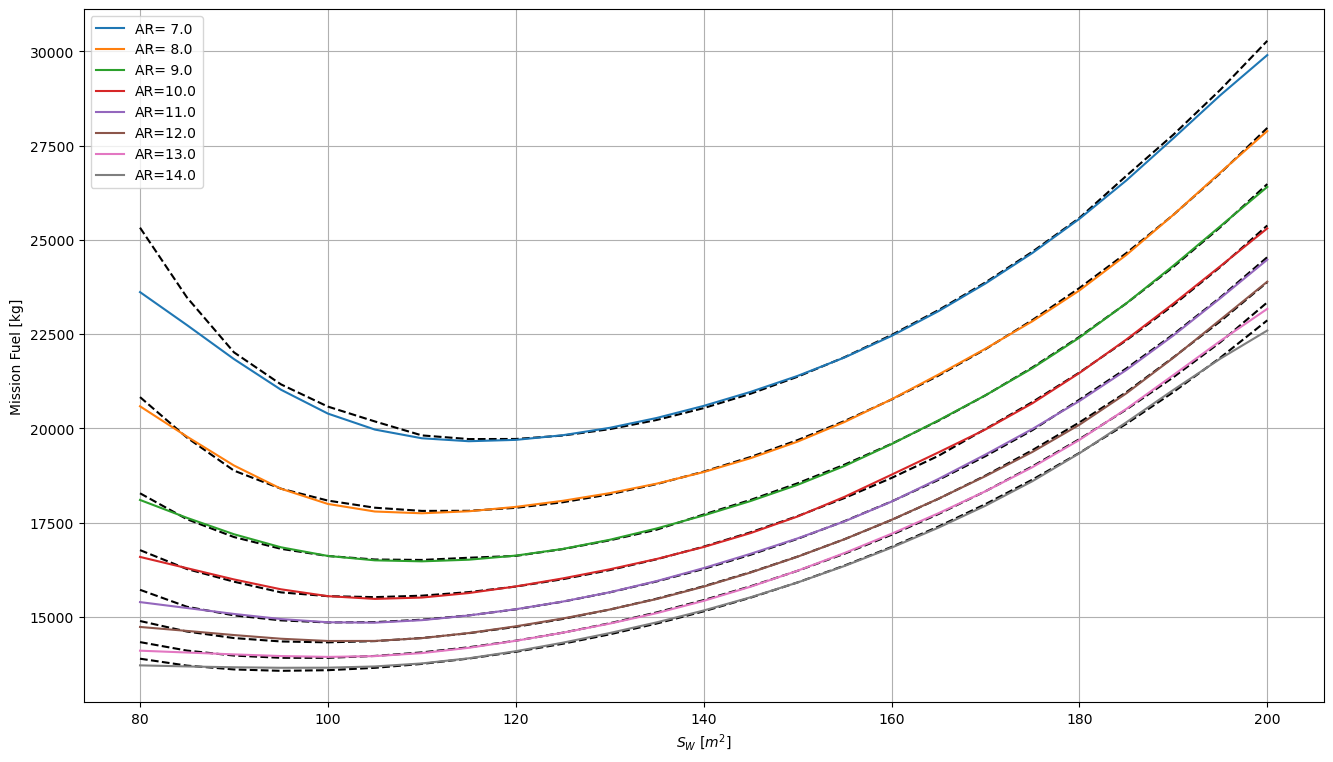

In [27]:
Y_PREDICT_norm = model.predict(X_VALID_norm)

Y_PREDICT = out_normalizer.denormalize(Y_PREDICT_norm)

XX = X_VALID[:,0].reshape((25,8))

YY = Y_PREDICT[:,0].reshape((25,8))

ARs = np.linspace(7,14,8)
AR_labels = ['AR={:4.1f}'.format(a) for a in ARs]

j = valid_cols.index('w_fuel')

Y_VALID = valid_data[:,j]

YY_V = Y_VALID.reshape((25,8))

fig,ax = plt.subplots(figsize=(16,9))
ax.plot(XX,YY_V, linestyle='--', color='k')
ax.plot(XX,YY, label=AR_labels)
ax.grid()
ax.set_xlabel('$S_W$ [$m^2$]')
ax.set_ylabel('Mission Fuel [kg]')
ax.legend()
plt.show()

In [14]:
YY_V

array([[25324.88602528, 20829.78698653, 18277.60263895, 16769.55950628,
        15716.53659692, 14888.6434423 , 14328.54578146, 13888.62049633],
       [23472.62128209, 19755.21261269, 17589.00740932, 16267.18666892,
        15266.47379579, 14609.16968823, 14103.76404089, 13705.09437096],
       [22017.13764896, 18879.00652475, 17116.64827042, 15931.956959  ,
        15037.75702106, 14436.21627709, 13971.58529594, 13603.59453954],
       [21167.84363654, 18399.89795185, 16803.71812098, 15648.45180041,
        14905.3458143 , 14345.87163301, 13911.87410925, 13566.84346825],
       [20577.51197844, 18083.4490495 , 16613.25395971, 15547.68596262,
        14850.04453305, 14322.38156977, 13911.41047886, 13583.53561966],
       [20183.48304962, 17894.69766569, 16520.56216659, 15522.0447717 ,
        14858.93721107, 14355.21973477, 13961.422789  , 13646.22331311],
       [19813.39081227, 17809.81798725, 16508.96072837, 15560.4746134 ,
        14923.34180729, 14437.38922597, 14056.14989858, 13